In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
tensorflow.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [ ]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [10]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [11]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './multi_level/fog_dataset_extend_multilevels.hdf'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)


# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']
df_train['delta_theta'] = df_train['theta925'] - df_train['theta1000']
df_train['delta_theta_e'] = df_train['theta_e925'] - df_train['theta_e1000']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']
df_valid['delta_theta'] = df_valid['theta925'] - df_valid['theta1000']
df_valid['delta_theta_e'] = df_valid['theta_e925'] - df_valid['theta_e1000']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']
df_test['delta_theta'] = df_test['theta925'] - df_test['theta1000']
df_test['delta_theta_e'] = df_test['theta_e925'] - df_test['theta_e1000']

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour','delta_theta','delta_theta_e','theta_e925']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.fit_transform(valid_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]




['/test', '/train', '/valid']
(75995, 18)
(75995,)


In [12]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', 
                                kernel_regularizer=regularizers.l2(0.0001),
                                input_shape=train_x.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation = 'relu'))
        model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = KerasRegressor(build_fn = build_model)
# callbacks = [keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4)]
# history = sklearn_model.fit(train_x_scaled, train_y,
#                             epochs = 50,
#                             validation_data = (valid_x_scaled, valid_y),
#                             callbacks = callbacks)

C:\Users\Henry\AppData\Local\Temp\ipykernel_22532\1571354641.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = KerasRegressor(build_fn = build_model)


In [13]:
from scipy.stats import reciprocal

# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4, 5, 6, 7],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
}
callbacks = [keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4)]
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(train_x_scaled, train_y, epochs = 500,
                     validation_data = (valid_x_scaled, valid_y),
                     callbacks = callbacks)

Epoch 1/100
1584/1584 [==============================] - 5s 3ms/step - loss: 0.5920 - val_loss: 0.3090
Epoch 2/100
1584/1584 [==============================] - 4s 3ms/step - loss: 0.3928 - val_loss: 0.2781
Epoch 3/100
1584/1584 [==============================] - 4s 3ms/step - loss: 0.3521 - val_loss: 0.2638
Epoch 4/100
1584/1584 [==============================] - 4s 3ms/step - loss: 0.3280 - val_loss: 0.2530
Epoch 5/100
1584/1584 [==============================] - 4s 3ms/step - loss: 0.3078 - val_loss: 0.2446
Epoch 6/100
1584/1584 [==============================] - 4s 3ms/step - loss: 0.2974 - val_loss: 0.2396
Epoch 7/100
1584/1584 [==============================] - 4s 3ms/step - loss: 0.2876 - val_loss: 0.2327
Epoch 8/100
1584/1584 [==============================] - 4s 3ms/step - loss: 0.2801 - val_loss: 0.2310
Epoch 9/100
1584/1584 [==============================] - 4s 3ms/step - loss: 0.2735 - val_loss: 0.2273
Epoch 10/100
1584/1584 [==============================] - 4s 3ms/step - l

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000022A46D14100>,
                   n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4, 5, 6, 7],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002278A85A430>})

In [14]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)
model = random_search_cv.best_estimator_.model
model.evaluate(test_x_scaled, test_y)

{'hidden_layers': 2, 'layer_size': 96, 'learning_rate': 0.0006539044144409704}
-0.14186637103557587
466/466 [==============================] - 1s 2ms/step - loss: 0.2611


0.26110023260116577

In [19]:
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = callbacks)

Epoch 1/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1690 - val_loss: 0.1507
Epoch 2/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1688 - val_loss: 0.1512
Epoch 3/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1683 - val_loss: 0.1489
Epoch 4/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1692 - val_loss: 0.1494
Epoch 5/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1681 - val_loss: 0.1487
Epoch 6/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1676 - val_loss: 0.1479
Epoch 7/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1680 - val_loss: 0.1491
Epoch 8/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1677 - val_loss: 0.1480
Epoch 9/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.1682 - val_loss: 0.1487
Epoch 10/50
2375/2375 [==============================] - 6s 3ms/step - loss: 0.165

In [ ]:

model_path = os.path.join(file_dir, './multi_level/seafog_hpsearch_multi_reg.tf')
tf.keras.models.save_model(
    model, model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

In [20]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_164 (Dense)           (None, 96)                1824      
                                                                 
 dense_165 (Dense)           (None, 96)                9312      
                                                                 
 dropout_69 (Dropout)        (None, 96)                0         
                                                                 
 dense_166 (Dense)           (None, 1)                 97        
                                                                 
Total params: 11,233
Trainable params: 11,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [ ]:
type(history)

In [ ]:
history.history

In [ ]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [21]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.26444485783576965

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3
* hp 搜索后MSE达到了0.245

In [22]:
predictions = model(test_x_scaled).numpy()
predictions

array([[0.44701576],
       [0.6442343 ],
       [0.5199771 ],
       ...,
       [3.0248413 ],
       [2.7229419 ],
       [1.9041433 ]], dtype=float32)

In [23]:
r,p = pearsonr(predictions[:,0],test_y)
print(f'相关系数{r}, p值为{p:.5f}')

相关系数0.5915236553245014, p值为0.00000


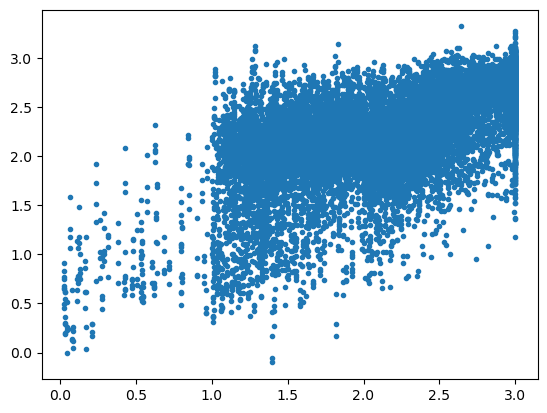

In [24]:
plt.plot(test_y, predictions,'.')
plt.show()

In [ ]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 